In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import zipfile
import os

## Розархівування файлу з даними

In [2]:
direct = "/kaggle/working/"


with zipfile.ZipFile(r"/kaggle/input/dogs-vs-cats/train.zip", "r") as zip_ref:
  zip_ref.extractall(direct)

with zipfile.ZipFile(r"/kaggle/input/dogs-vs-cats/test1.zip", "r") as zip_ref:
  zip_ref.extractall(direct)


In [3]:
# Як має виглядити submission

example = pd.read_csv(f"/kaggle/input/dogs-vs-cats/sampleSubmission.csv")
example

,id,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
12495,12496,0
12496,12497,0
12497,12498,0
12498,12499,0


In [4]:
print(f"{example.describe()}\n")
print(example.info())

                 id    label
count  12500.000000  12500.0
mean    6250.500000      0.0
std     3608.583517      0.0
min        1.000000      0.0
25%     3125.750000      0.0
50%     6250.500000      0.0
75%     9375.250000      0.0
max    12500.000000      0.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      12500 non-null  int64
 1   label   12500 non-null  int64
dtypes: int64(2)
memory usage: 195.4 KB
None


## Об'єднання та візуалізація даних

In [5]:
# train для навчання, test - для перевірки

img_train = os.listdir(f"{direct}/train")
print(img_train[:20])

img_test = os.listdir(f"{direct}/test1")
print(img_test[:10])

['cat.6972.jpg', 'dog.1872.jpg', 'cat.8521.jpg', 'dog.7228.jpg', 'cat.8367.jpg', 'cat.5633.jpg', 'dog.3770.jpg', 'dog.6124.jpg', 'dog.6153.jpg', 'dog.10678.jpg', 'dog.10270.jpg', 'dog.8517.jpg', 'cat.1758.jpg', 'cat.5530.jpg', 'dog.11739.jpg', 'dog.9598.jpg', 'cat.10661.jpg', 'cat.11745.jpg', 'dog.11885.jpg', 'cat.6059.jpg']
['7434.jpg', '3258.jpg', '8771.jpg', '1906.jpg', '8619.jpg', '4846.jpg', '4494.jpg', '771.jpg', '211.jpg', '4806.jpg']


In [6]:
dictionary = {
    "filename": [],
    "id": [],
    "label": []
}

for i in img_train:
  dictionary["filename"].append(i)
  dictionary["id"].append(i.split(".")[1])
  dictionary["label"].append(i.split(".")[0])


df = pd.DataFrame(dictionary)
df

,filename,id,label
0,cat.6972.jpg,6972,cat
1,dog.1872.jpg,1872,dog
2,cat.8521.jpg,8521,cat
3,dog.7228.jpg,7228,dog
4,cat.8367.jpg,8367,cat
...,...,...,...
24995,dog.4301.jpg,4301,dog
24996,dog.7185.jpg,7185,dog
24997,dog.3991.jpg,3991,dog
24998,cat.12202.jpg,12202,cat


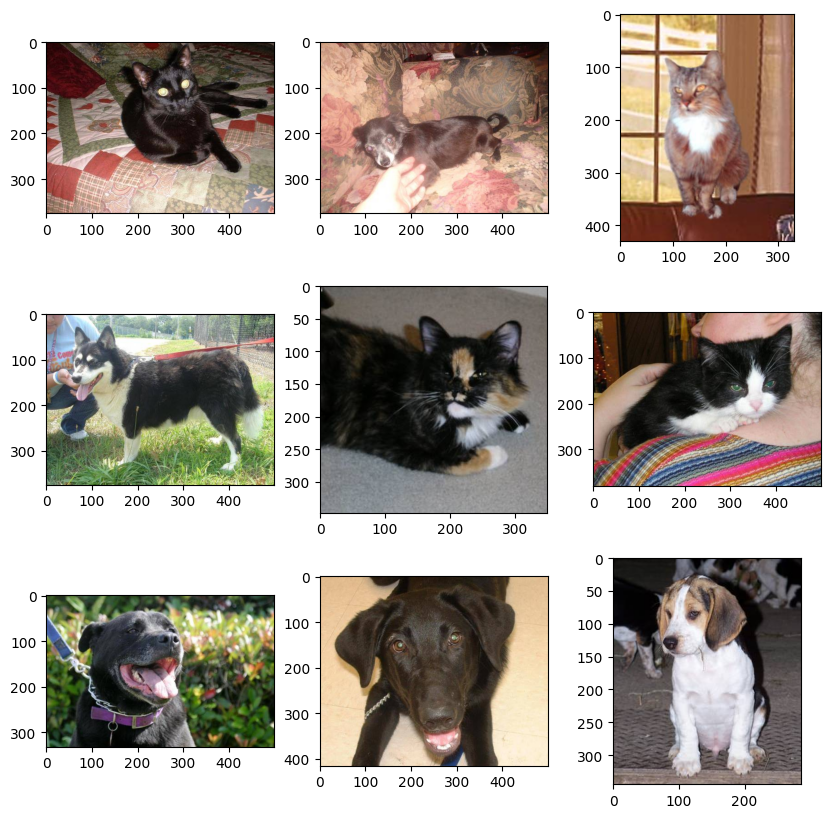

In [7]:
from matplotlib.image import imread


tr_dir = f"{direct}/train"

plt.figure(figsize=(10, 10))

for i in range(0, 9):
  plt.subplot(3, 3, i + 1)
  plt.subplots_adjust()
  img = imread(f"{tr_dir}/{img_train[i]}")
  plt.imshow(img, cmap=plt.cm.binary)

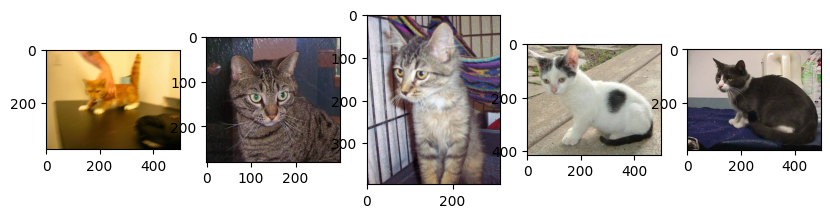

In [8]:
plt.figure(figsize=(10, 10))

for i in range(5):
  plt.subplot(1, 5, i + 1)
  plt.subplots_adjust()
  img_dog = imread(f"{tr_dir}/cat.{i}.jpg")
  plt.imshow(img_dog, cmap=plt.cm.binary)

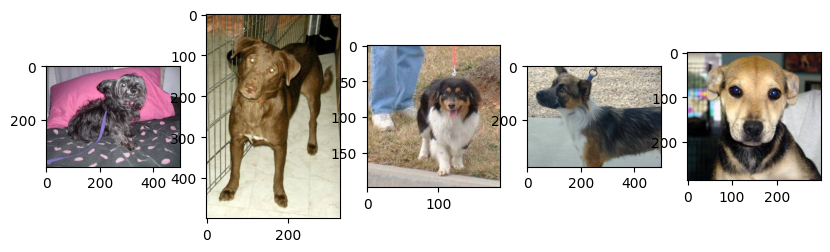

In [9]:
plt.figure(figsize=(10, 10))

for i in range(5):
  plt.subplot(1, 5, i + 1)
  plt.subplots_adjust()
  img_dog = imread(f"{tr_dir}/dog.{i}.jpg")
  plt.imshow(img_dog, cmap=plt.cm.binary)


num_classes = 2
classes = {0: "cat", 1: "dog"}

## Розбиття даних

In [71]:
from sklearn.model_selection import train_test_split


X = df[["filename", "label"]]


print(X)
print(f"\nX shape: {X['filename'].shape}, y shape: {X['label'].shape}")

            filename label
0       cat.6972.jpg   cat
1       dog.1872.jpg   dog
2       cat.8521.jpg   cat
3       dog.7228.jpg   dog
4       cat.8367.jpg   cat
...              ...   ...
24995   dog.4301.jpg   dog
24996   dog.7185.jpg   dog
24997   dog.3991.jpg   dog
24998  cat.12202.jpg   cat
24999  cat.10686.jpg   cat

[25000 rows x 2 columns]

X shape: (25000,), y shape: (25000,)


In [72]:
X_train, X_valid = train_test_split(X, test_size=0.2, random_state=42)



print(f"X_train shape: {X_train.shape}")
print(f"X_valid shape: {X_valid.shape}")

X_train shape: (20000, 2)
X_valid shape: (5000, 2)


## Image generator

Для роботи з генераторами картинок є дві дієві функції передачі даних з картинки (`flow_from_dataframe` і `flow_from_directory`), де для першої у вигляді "X" має бути DataFrame і з "X" і з "y", а для другої шлях до папки з картинками та датафрейм? з їхніми назвами.

Я використаю flow_from_dataframe, тому розбиваємо дані так, щоб "X" у мене були датафреймом і з "y" також.

In [73]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory=tr_dir,
    x_col="filename",
    y_col="label",
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary")

valid_generator = train_datagen.flow_from_dataframe(
    X_valid,
    tr_dir,
    x_col = "filename",
    y_col="label",
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary")

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


## Архітектура та навчання CNN

In [13]:
from keras.models import Sequential 
from keras import layers
from keras import models
from keras.layers import Dense, MaxPooling2D, Dropout, Flatten, BatchNormalization, Conv2D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

### CNN Model #1

In [14]:
model = Sequential([
    Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64,(3,3),activation="relu"),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    BatchNormalization(),

    Conv2D(128,(3,3),activation="relu"),
    MaxPooling2D(2, 2),

    Flatten(),

    Dense(512, activation="relu"),
    Dense(1,activation="softmax")

])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [15]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 31, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,585 (49.36 MB)

 Trainable params: 12,939,457 (49.36 MB)

 Non-trainable params: 128 (512.00 B)

In [18]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 465s 739ms/step - accuracy: 0.4946 - loss: 1.3068 - val_accuracy: 0.5068 - val_loss: 0.6931
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 460s 736ms/step - accuracy: 0.4976 - loss: 0.6932 - val_accuracy: 0.5068 - val_loss: 0.6932
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 457s 731ms/step - accuracy: 0.5025 - loss: 0.6932 - val_accuracy: 0.5068 - val_loss: 0.6933
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 458s 733ms/step - accuracy: 0.4902 - loss: 0.6932 - val_accuracy: 0.5068 - val_loss: 0.6931
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 501s 732ms/step - accuracy: 0.5044 - loss: 0.6932 - val_accuracy: 0.5068 - val_loss: 0.6931
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 468s 748ms/step - accuracy: 0.5018 - loss: 0.6944 - val_accuracy: 0.5068 - val_loss: 0.6934
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 467s 747ms/step - accuracy: 0.5065 - loss: 0.6884 - val_accuracy: 0.5068 - val_loss: 0.6734
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 466s 744ms/step - accuracy: 0.4943 - loss: 0.66

### CNN Model #2

In [58]:
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(32,(3,3),activation="relu"),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    BatchNormalization(),

    Conv2D(64,(3,3),activation="relu"),
    MaxPooling2D(2, 2),
    
    Conv2D(128,(3,3),activation="relu"),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Flatten(),

    Dense(512, activation="relu"),
    Dense(1,activation="softmax")

])

In [59]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [60]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_46 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 61, 61, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,463,457 (9.40 MB)

 Trainable params: 2,463,137 (9.40 MB)

 Non-trainable params: 320 (1.25 KB)

In [61]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=valid_generator,
    batch_size=128
)

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 331s 522ms/step - accuracy: 0.5012 - loss: 0.8836 - val_accuracy: 0.5068 - val_loss: 1.4261
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 328s 524ms/step - accuracy: 0.4977 - loss: 0.4899 - val_accuracy: 0.5068 - val_loss: 0.6649
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 328s 524ms/step - accuracy: 0.4977 - loss: 0.4181 - val_accuracy: 0.5068 - val_loss: 0.5416
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 321s 513ms/step - accuracy: 0.5021 - loss: 0.3504 - val_accuracy: 0.5068 - val_loss: 0.5597
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 324s 516ms/step - accuracy: 0.5026 - loss: 0.2694 - val_accuracy: 0.5068 - val_loss: 0.3919
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 326s 521ms/step - accuracy: 0.4961 - loss: 0.1986 - val_accuracy: 0.5068 - val_loss: 0.4438
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 373s 506ms/step - accuracy: 0.5030 - loss: 0.1397 - val_accuracy: 0.5068 - val_loss: 0.5596
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 321s 505ms/step - accuracy: 0.4965 -

## Навчання на розбитті X_train

In [74]:
x_te, x_val = train_test_split(X_train, test_size=0.2, random_state=42)

print(f"x_te: {x_te.shape}, x_val: {x_val.shape}")

x_te: (16000, 2), x_val: (4000, 2)


In [75]:
# train_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)


te_generator = train_datagen.flow_from_dataframe(
    dataframe=x_te,
    directory=tr_dir,
    x_col="filename",
    y_col="label",
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary")

val_generator = train_datagen.flow_from_dataframe(
    x_val,
    tr_dir,
    x_col = "filename",
    y_col="label",
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary")

Found 16000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.


In [64]:
model = Sequential([
    Conv2D(64, (3, 3), activation="relu", input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(128,(3,3),activation="relu"),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    BatchNormalization(),

    Conv2D(128,(3,3),activation="relu"),
    MaxPooling2D(2, 2),

    Flatten(),

    Dense(512, activation="relu"),
    Dense(1,activation="softmax")

])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [65]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [66]:
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_50 (Conv2D)              │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,069,825 (49.86 MB)

 Trainable params: 13,069,569 (49.86 MB)

 Non-trainable params: 256 (1.00 KB)

In [69]:
s_history = model.fit(
    te_generator,
    epochs=10,
    validation_data=val_generator,
    batch_size=128
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4959 - loss: 1.6010

/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


500/500 ━━━━━━━━━━━━━━━━━━━━ 861s 2s/step - accuracy: 0.4959 - loss: 1.5995 - val_accuracy: 0.4980 - val_loss: 0.6963
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 858s 2s/step - accuracy: 0.5021 - loss: 0.6384 - val_accuracy: 0.4980 - val_loss: 0.6077
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 840s 2s/step - accuracy: 0.4983 - loss: 0.5457 - val_accuracy: 0.4980 - val_loss: 0.5619
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 855s 2s/step - accuracy: 0.5079 - loss: 0.4668 - val_accuracy: 0.4980 - val_loss: 1.6140
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 853s 2s/step - accuracy: 0.4981 - loss: 0.4167 - val_accuracy: 0.4980 - val_loss: 0.5201
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 844s 2s/step - accuracy: 0.5063 - loss: 0.3493 - val_accuracy: 0.4980 - val_loss: 0.4234
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 853s 2s/step - accuracy: 0.4992 - loss: 0.2794 - val_accuracy: 0.4980 - val_loss: 0.4836
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 878s 2s/step - accuracy: 0.4988 - loss: 0.2212 - val_accuracy: 0.498

## Аугментація даних 

In [89]:
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)


train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    X_train,
    tr_dir,
    x_col="filename",
    y_col="label",
    target_size=(150, 150),
    batch_size=20,
    class_mode="binary"
)

valid_generator = train_datagen.flow_from_dataframe(
    X_valid,
    tr_dir,
    x_col = "filename",
    y_col="label",
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary")

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


## Навчання на аугментованих даних

In [90]:
aug_model = Sequential([
    Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64,(3,3),activation="relu"),
    MaxPooling2D(2, 2),
    Dropout(0.2),
#     BatchNormalization(),

    Conv2D(128,(3,3),activation="relu"),
    MaxPooling2D(2, 2),

    Flatten(),

    Dense(512, activation="relu"),
    BatchNormalization(),
    Dense(1,activation="softmax")

])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [91]:
aug_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [92]:
aug_model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_62 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 73, 73, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,036,225 (72.62 MB)

 Trainable params: 19,035,201 (72.61 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [93]:
aug_history = aug_model.fit(
    train_generator_augmented,
    epochs=10,
    validation_data=valid_generator,
    batch_size=64
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 887s 880ms/step - accuracy: 0.5016 - loss: 0.7158 - val_accuracy: 0.5068 - val_loss: 0.6478
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 929s 887ms/step - accuracy: 0.5007 - loss: 0.6321 - val_accuracy: 0.5068 - val_loss: 0.5754
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 900s 865ms/step - accuracy: 0.4983 - loss: 0.5934 - val_accuracy: 0.5068 - val_loss: 0.5252
Epoch 4/10
 459/1000 ━━━━━━━━━━━━━━━━━━━━ 7:25 824ms/step - accuracy: 0.4965 - loss: 0.5637

KeyboardInterrupt: 